# TMD maps with one-D potential 

Here we will aim to measure the effect of prefactor reduction in a 1D case of TMD map. Note that our error model is of the form: 

$$ |L^{(n)}_{\epsilon,\mu}f(x) - \mathcal{L}f(x)| \sim \frac{V(x)}{\sqrt{n}\epsilon^{2 + d/4}} + \epsilon B(x) $$

Here $V$ and $B$ are variance and bias error prefactors respectively. The 1-D setup is as follows: 

1. $V: \mathbb{R} \to \mathbb{R}$ is a (coercive) potential. 
2. The system $X_t$ is governed by the SDE: 
$\begin{align}dX_t = -\nabla V(X_t) + \sqrt{2\beta^{-1}} dW_t \end{align} $
3. The ergodic measure is $\propto \exp{\left(-\beta V(x)\right)}$
4. The committor satisfies: 
$$\begin{align}\Delta q - \beta\nabla V(x) \cdot \nabla q(x) = 0,\:\: q\mid_{\partial A} = 0\, q\mid_{\partial B} = 1 \end{align}$$

Here $A = \{x < a\}$, $B = \{x > b\}$. The committor function can be given analytically for $x \in (a,b)$: 

$$ q(x) = \frac{\int_{a}^{x}\exp{\left(-\beta V(x)\right)}\,dx}{\int_{a}^{b}\exp{\left(-\beta V(x)\right)}\,dx}$$

A good 1-D potential is 

$$ V(x) = (x^2 - 1)^2 $$

We set 

$$ A = \{x < -0.8 \}, \: B = \{x > -0.8 \}$$

In [3]:
import os
import copy
import sys 
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__),'..')))
sys.path.append("..")

# Regular Modules
import numpy as np
import sklearn as sklearn
import matplotlib.pyplot as plt
import datetime
import scipy.integrate as scint
#from numpy.random import default_rng
import numpy.ma as ma
import matplotlib.tri as tri
import scipy.io
import time 
from mpl_toolkits.mplot3d import axes3d
import argparse

# parallelization modules 
from math import nan
from joblib import Parallel, delayed
import multiprocess
import itertools
import tqdm

# # My Modules
import src.model_systems as model_systems
import src.helpers as helpers
import src.potentials as potentials
import src.diffusion_map as diffusion_map
from src.fem.distmesh import * 
from src.fem.FEM_TPT import *
import src.sampling as sampling

How to do this: 

1. Set up drift, potential, invariant measure, committor. 

2. Set up two datasets: uniform, normal random variable centered @ 0. 

3. Set up TMD map kernel for each set. This will involve picking epsilon, N. Don't use knn sparsification. Compare KDE's. 

4. Approximate $\mathcal{L}$ on some simple $f$ (say $f = x^5 - x$) by plugging in the analytical form for $\mathcal{L}f = f'' - V'(x)f'(x)$. 

In [4]:
# set up params
beta = 1 
d = 1
def potential(x): 
    return (x**2 - 1)**2 

def drift(x): 
    return 4*x*(x**2 - 1)

Z = scint.quad(lambda x: np.exp(-beta*potential(x)), -50, 50)[0]

def mu(x): return (1/Z)*np.exp(-beta*potential(x))

ϵ = 1/(10**(6/5))

In [68]:
# set up dataset for uniform estimation 

N = int(1e4)
# uniform = np.linspace(-2,2,int(N+1)).reshape(N+1,d) # note that p = uniform[0,N/2]
uniform = np.random.uniform(-2.0,2.0,N+1).reshape(N+1,d)
uniform[N,0] = 0.0
target_measure_uniform = np.zeros(N+1)

for i in range(N+1):
    target_measure_uniform[i] = mu(uniform[i,:])

target_dmap_uniform = diffusion_map.TargetMeasureDiffusionMap(epsilon=ϵ, n_neigh=int(N), \
                                                          target_measure=target_measure_uniform)
target_dmap_uniform.construct_generator(uniform.T)
K_uniform = target_dmap_uniform.get_kernel()
L_uniform = target_dmap_uniform.get_generator() 

In [69]:
# set up dataset for biased estimation 
N = int(1e4)
biased = np.random.randn(int(N+1)).reshape(N+1,d) # p = biased[N]
biased[N,0] = 0.0
target_measure_biased = np.zeros(N+1)
for i in range(N+1):
    target_measure_biased[i] = mu(biased[i,:])

target_dmap_biased = diffusion_map.TargetMeasureDiffusionMap(epsilon=ϵ, n_neigh=int(N), \
                                                          target_measure=target_measure_biased)
target_dmap_biased.construct_generator(biased.T)
K_biased = target_dmap_biased.get_kernel()
L_biased = target_dmap_biased.get_generator() 

In [70]:
def f(x): return x**6 - x
def Lf(x): return 30*(x**4) - beta*4*x*(x**2-1)*(6*(x**5) - 1)

In [71]:
# derivative on uniform set 
F_uniform = f(uniform)
LF_uniform_true = Lf(uniform)
LF_uniform_TMD = L_uniform@F_uniform 

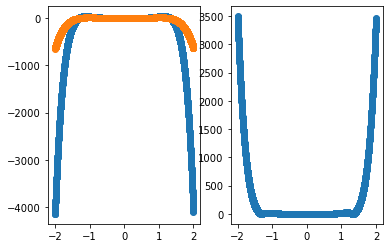

In [72]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter(uniform, LF_uniform_true)
ax1.scatter(uniform, LF_uniform_TMD)
ax2.scatter(uniform, np.abs(LF_uniform_true-LF_uniform_TMD))

In [73]:
# checking KDE 
rho_epsilon_uniform = (1/(N+1))*(1/(2*np.pi*ϵ)**(d/2))*K_uniform@np.ones((N+1,1))

In [74]:
rho_epsilon_uniform

array([[0.24605336],
       [0.25840654],
       [0.19557485],
       ...,
       [0.24007898],
       [0.24621611],
       [0.2487663 ]])

In [43]:
# derivative on biased set 
F_biased = f(biased)
LF_biased_true = Lf(biased)
LF_biased_TMD = L_biased@F_biased

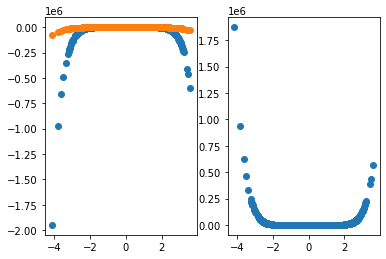

In [44]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter(biased, LF_biased_true)
ax1.scatter(biased, LF_biased_TMD)
ax2.scatter(biased, np.abs(LF_biased_true-LF_biased_TMD))

In [61]:
# checking KDE 
rho_epsilon_biased = (1/(N+1))*(1/(2*np.pi*ϵ)**(d/2))*K_biased@np.ones((N+1,1))

In [60]:
(1/np.sqrt(pi))

array([[0.04757883],
       [0.55407295],
       [0.45660978],
       ...,
       [0.25638387],
       [0.54872639],
       [0.55365364]])